# Congenital Central Hypoventilation syndrome ("Ondine syndrome") from an existing network

This notebook assumes that you have read **NORDic Network Identification (NI) Part I**. 

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.6.0


## Parameters for NORDic (from Part I)

In [2]:
file_folder="MODELS/Ondine_existing_network/" ## the folder name is changed

Refer to Part I for further details.

In [3]:
## Registration to databases
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"
STRING_credentials = "../tests/credentials_STRING.txt"
LINCS_credentials = "../tests/credentials_LINCS.txt"

## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)
taxon_id=9606 # human species
disease_cids=["C1275808"] 
cell_lines=["NPC", "SHSY5Y"]

## Information about the disease
DISGENET_args = {
        "credentials": DisGeNET_credentials, "disease_cids": disease_cids,
}

## Selection of parameters relative to the prior knowledge network 
STRING_args = {
        "credentials": STRING_credentials, "score": 0,
}
EDGE_args = {
        "tau": 0, "filter": True, "connected": True, 
}

accept_nonRNA=True

## Selection of parameters relative to experimental constraints
LINCS_args = {
        "path_to_lincs": "lincs/", "credentials": LINCS_credentials,
        "cell_lines": cell_lines, "thres_iscale": None,
}
SIG_args = {
        "bin_thres": 0.5,
}

force_experiments=False

## Selection of parameters relative to the inference of networks
BONESIS_args = {
        "limit": 1, "exact": True, "max_maxclause": 3,
}

## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Using an existing network in NORDic

The network inferred in **NORDic Network Identification (NI) Part I** might not be very interesting, due to the small number of genes. **NORDic** allows feeding an existing network to the network identification pipeline, which means that the set of genes and/or a putative prior knowledge network are provided to the pipeline.

Since version 2.2.3, **NORDic** may infer the sign of the edges in the prior knowledge network using the gene expression data retrieved from **LINCS L1000**, instead of using the sign of the edge-related scores in the network stored at "network_fname", by setting option *preserve_network_sign* to **False**. The default behavior is *preserve_network_sign=* **True**, and is consistent with the behavior of past versions of **NORDic**.

In [4]:
preserve_network_sign=True

### A. Structure of an input network to **NORDic**

Any network in input to **NORDic** is a table where each row corresponds to a single edge, with 5 columns:
- "preferredName_A" name of the input node in the edge
- "preferredName_B" name of the output node
- "sign" sign of the interaction (activatory: 1, inhibitory: -1, non monotonous: 2)
- "directed" is that edge directed from A to B? (0: undirected, 1: directed)
- "score" confidence score assigned to that edge

In this example, we will retrieve a set of protein actions involving genes from the previous network, from the STRING databases, using function *get_interactions_from_STRING*, that will automatically convert that set of interactions into a proper network for **NORDic**. In particular, it will add all genes which are connected to the set of genes in the previous network.

In [5]:
from NORDic.UTILS.STRING_utils import get_interactions_from_STRING

with open("MODELS/Ondine/solution.bnet", "r") as f:
    gene_list = [s.split(", ")[0] for s in f.read().split("\n")]
gene_list

['ASCL1', 'BDNF', 'EDN3', 'GDNF', 'LBX1', 'PHOX2B', 'RET']

In [6]:
from subprocess import call as sbcall
sbcall("mkdir -p "+file_folder, shell=True)

## Get physical interactions from the STRING database involving the list of genes in input
PPI = get_interactions_from_STRING(gene_list, taxon_id, version="11.0", strict=False, 
                                   #strict=False adds genes involved with genes in gene_list
                                   min_score=0.5, app_name="NORDic_packagePartII",
                                   file_folder=file_folder)

## Save the corresponding network into a CSV file
NETWORK_fname = file_folder+"full_PPI.tsv"
PPI.to_csv(NETWORK_fname, sep="\t", index=None)

PPI

<STRING> Retrieving the file from STRING... Saved at MODELS/Ondine_existing_network/protein_action_v11.0.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes
... Protein identifier matching
... Signed
... Directed
... Aggregate info
... Solve conflicts on direction
... Solve conflicts on sign for directed edges
... Aggregate info again
... Remove multiple undirected edges
... Solve conflicts on sign for undirected edges
... Aggregate info once again


,preferredName_A,preferredName_B,sign,directed,score
0,FRS2,GDNF,2,0,0.900
1,GNB4,EDN3,2,0,0.901
2,OXT,EDN3,2,0,0.900
3,EDN3,CYSLTR2,2,0,0.900
4,GRB7,RET,2,0,0.905
...,...,...,...,...,...
467,PIK3R2,RET,2,0,0.909
468,EHD4,BDNF,2,1,0.900
469,BDNF,RIT1,2,0,0.902
470,OXT,EDN3,2,0,0.900


In [7]:
len(list(set(list(PPI["preferredName_A"])+list(PPI["preferredName_B"]))))

287

### B. Parameter finetuning

In [8]:
## "filter" is set to True, meaning that we filter out edges by correlation
EDGE_args.update({"tau": 0.05, "filter": True, "connected": False})

## "thres_iscale" is set to 0., meaning that experiments must have a corresponding
## interference scale score strictly higher than 0.
LINCS_args.update({"thres_iscale": 0.})

## Binarization threshold is set to 0.25
SIG_args.update({"bin_thres": 0.25})

## NORDic must enumerate at most 100 models (limit=100)
## which may use a subset of interactions from the prior knowledge network (exact=False)
## where the maximum number of disjunctive clauses is 3
BONESIS_args.update({"limit": 100, "exact": False, "max_maxclause": 3})

## No gene set is given
path_to_genes=None

## We use the PPI computed above
NETWORK_fname = file_folder+"full_PPI.tsv"

### C. Network identification using an existing network

In [9]:
from NORDic.NORDic_NI.functions import network_identification

larger_network_full = NORDic.NORDic_NI.functions.network_identification(file_folder, 
            taxon_id, path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args,
            edge_args=EDGE_args, sig_args=SIG_args,
            bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, network_fname=NETWORK_fname, njobs=njobs, 
            force_experiments=force_experiments, accept_nonRNA=accept_nonRNA,
            preserve_network_sign=preserve_network_sign)

100 solutions are already generated, and saved at MODELS/Ondine_existing_network/SOLUTIONS-100_binthres=0.250_thresiscale=0.0_score=0.00_maxclause=3_{1,...1}.zip
--- SELECTION OF OPTIMAL MODEL ---
100 solutions (100 unique solutions)a topological criteria...  ...
... 100 solutions (69/288 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 27 edges
<MODEL VISUALIZATION> Maximal solution: 288 edges
          1         2         3         4         5         6         7    \
GTP  0.862772  0.862966  0.876334  0.860098  0.860482  0.862577  0.826096   

          8         9         10        11        12        13        14   \
GTP  0.860291  0.860291  0.860098  0.862772  0.863158  0.862966  0.860098   

          15        16        17        18        19        20        21   \
GTP  0.866277  0.862772  0.815833  0.860295  0.862772  0.862577  0.860291   

          22        23        24        25        26        27        28   \
GTP  0.862772  0.874729  0.862966  0.87633

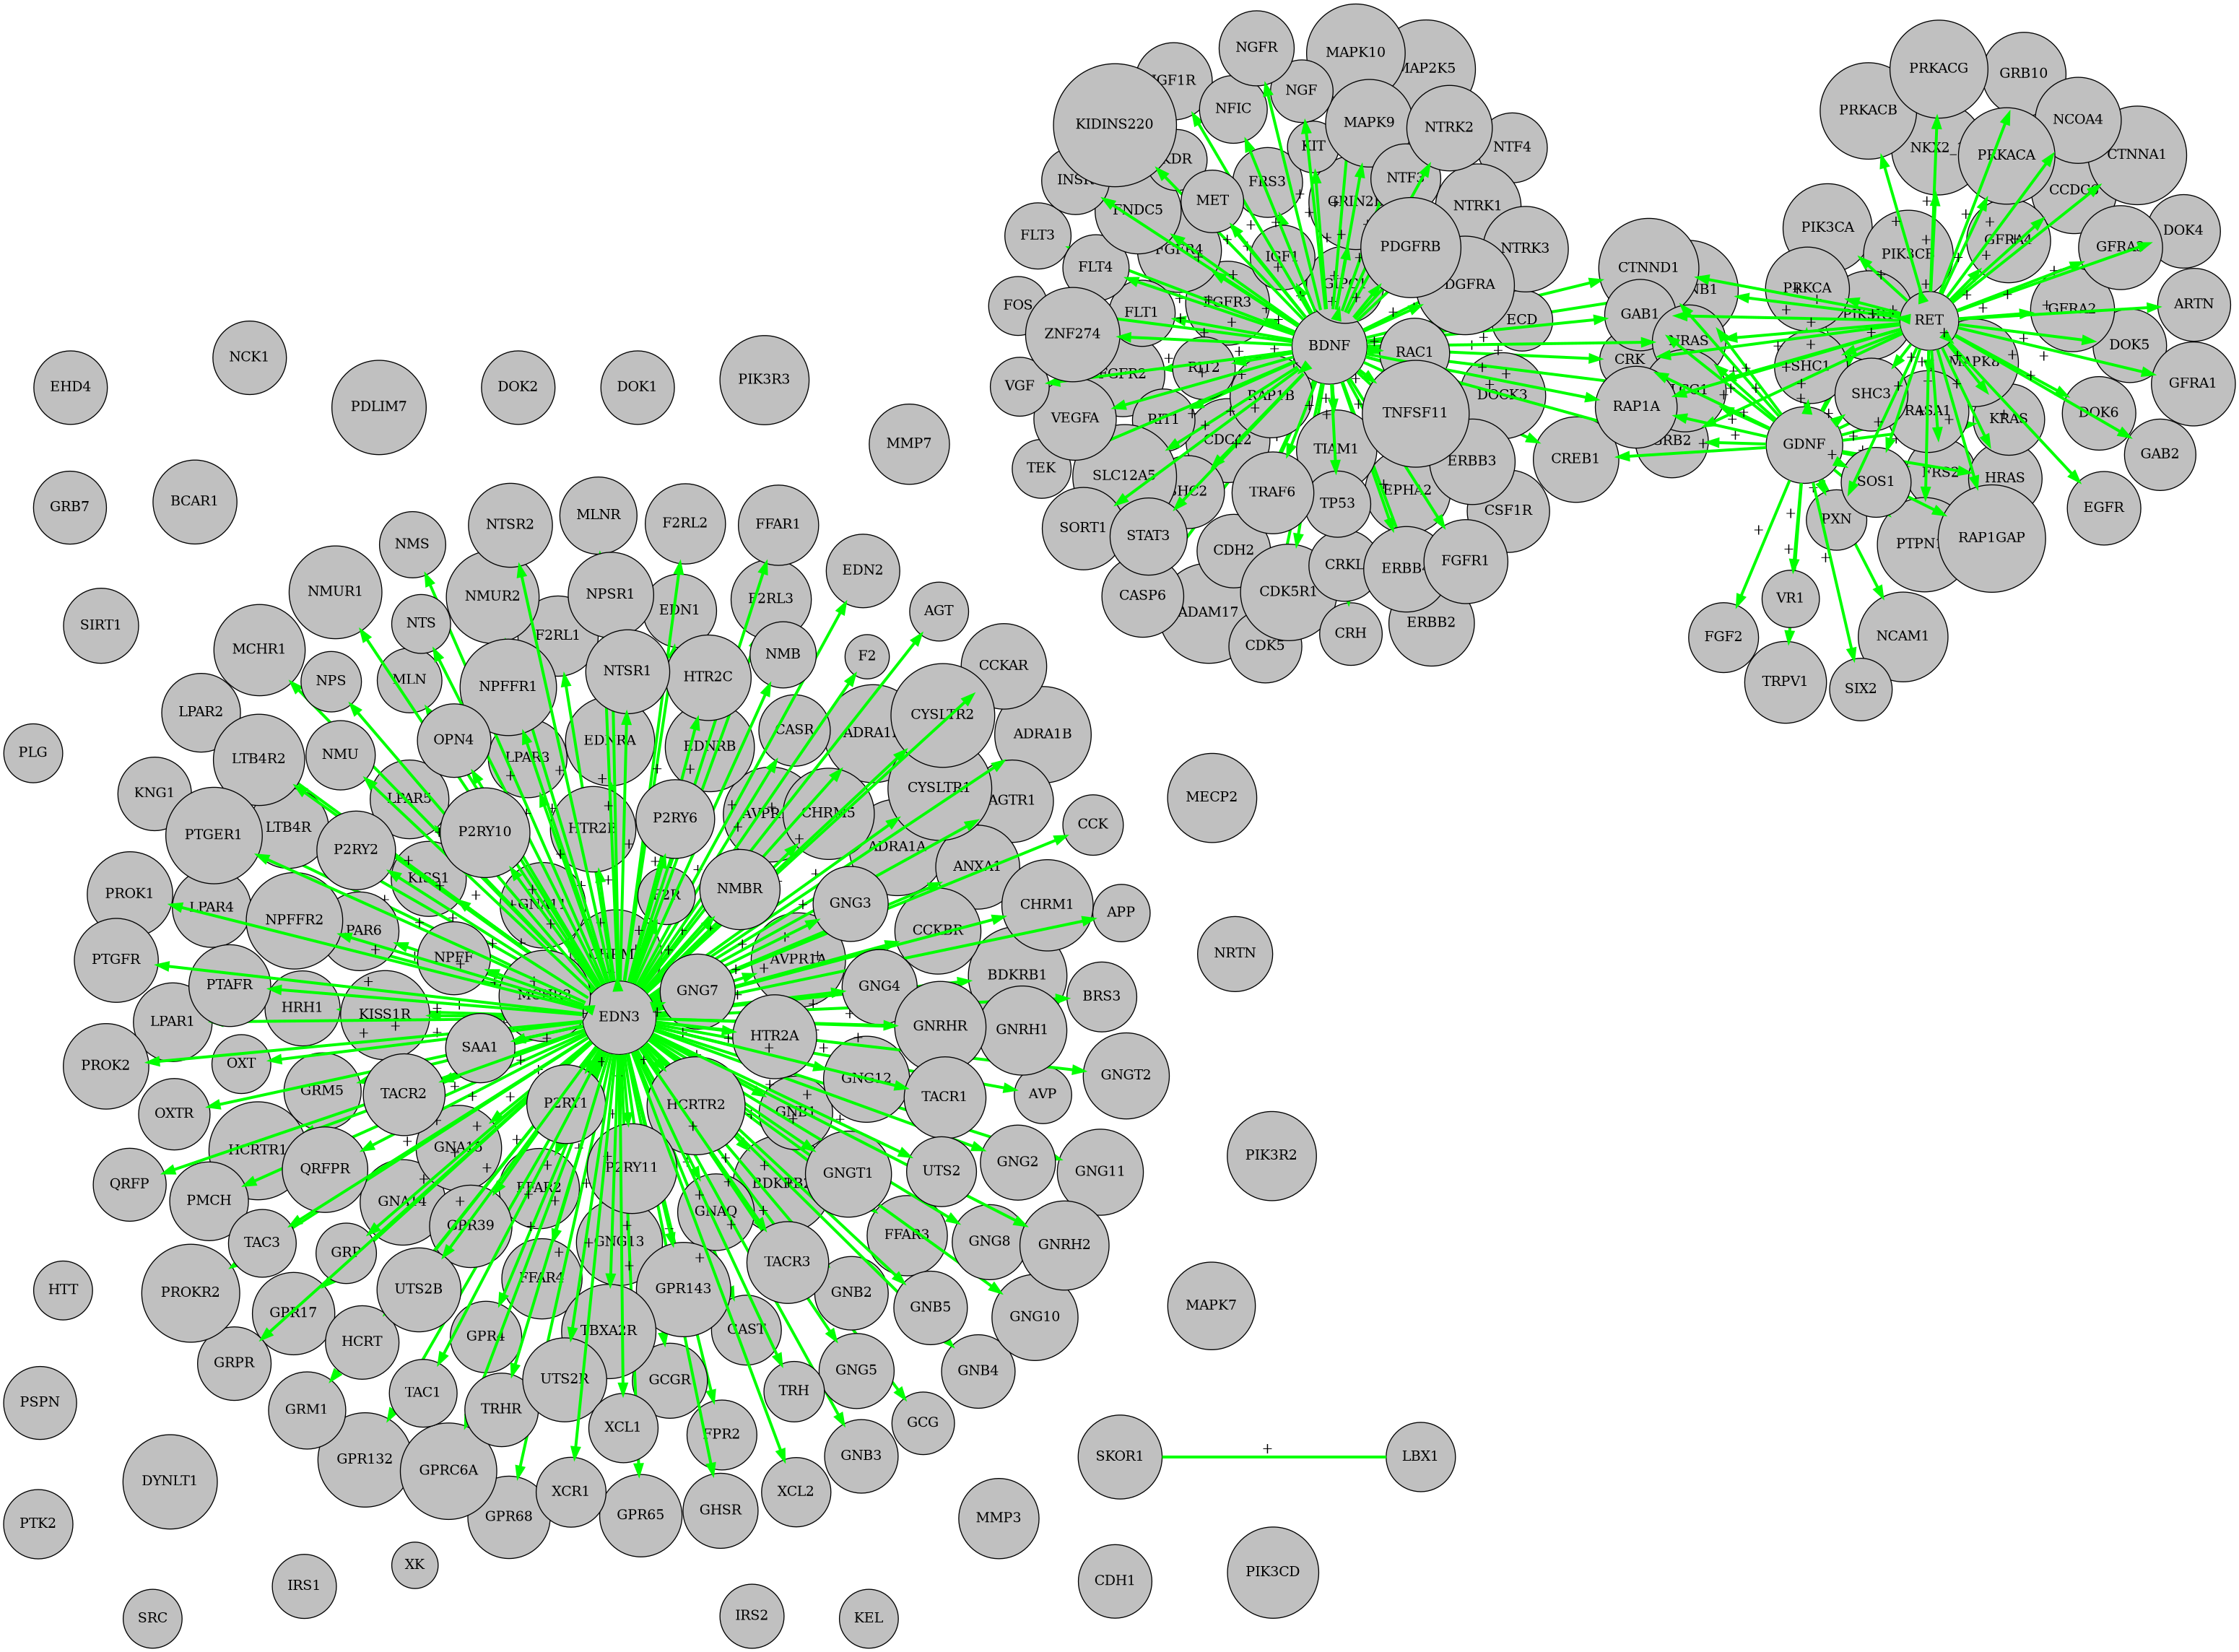

In [10]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

### D. Conclusion

In the next notebook (**Part III**), a network for CCHS will be inferred based on a pre-determined set of genes.